## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import os.path
from os import path
from collections import OrderedDict
import time


from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


## Custom Dataset Loading Class

In [2]:
label_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation',
              'Infiltration','Fibrosis','Pneumonia','No Finding']

In [3]:
def resolve_full_path(img_name):
    is_found = False

    # Read 1 image file
    folder_idx_range = 13
    img_path = ''
    for folder_idx in range(folder_idx_range):
        path_prefix = path.expanduser("~/data/kaggle/nih-chest-xrays/data/images_")
        path_suffix = "images/"
        cur_img_dir = path_prefix +str(folder_idx).zfill(3) +'/'
        img_folder_path = path.join(cur_img_dir, path_suffix)
        img_path = os.path.join(img_folder_path, img_name)

        if(path.exists(img_path)):
            is_found = True
            break
    if(not is_found):
        
        raise Exception('Couldn\'t find: {} last:{}'.format(img_name, img_path))
    return img_path
        
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path=None, data_frame=None, transform=None):
        if(csv_path is not None):
            self.data = pd.read_csv(csv_path)
        elif data_frame is not None:
            self.data = data_frame
        else:
            raise Exception('No csv path or data frame provided')

        self.data_len = len(self.data.index)            # csv data length
        
        self.image_names = np.array(self.data.iloc[:,0])  # image names
        self.heights = np.asarray(self.data.iloc[:,8])    # heights are at 8th column 
        self.widths =  np.asarray(self.data.iloc[:,7])    # widths are at  7th column
        
        # createa a tensor to store labels
        self.labels = torch.zeros(self.data_len, 15)
        labels = self.data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
        self.multi_hot_encoding_label(labels)
    
        self.transform = transform
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        # Read 1 image name
        img_name = self.image_names[index]
        img_path = resolve_full_path(img_name)
        img_as_img = Image.open(img_path)

        img_as_img = img_as_img.convert("RGB")
        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)

        # Read 1 label:
        image_label = self.labels[index]
        #print('image label: ', img_as_tensor[:10])
        #print('nonzero: ', img_name, np.nonzero(img_as_tensor))

        return img_as_tensor, image_label
    
    def multi_hot_encoding_label(self, labels):
            for i,label in enumerate(labels):
                for idx in range(len(label_list)):
                    if label_list[idx] in label:
                        self.labels[i][idx] = 1

## Define the model with Transfer learning

In [4]:
from torchvision import models

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

def create_model():
    
    # Import pre-trained densenet-121
    model = models.resnet18(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    # Change output to classfiy 14 conditioins + nothing.
    # Change a new classifier
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 15)
    )
    return model
model = create_model()
print(model)

Using device:  cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def calc_roc(y_test, y_score):
    #Compute ROC curve and ROC area for each class 
    fprs = [] 
    tprs = []
    roc = dict()
    roc_auc = dict() 
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i],pos_label=1) 
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc[i] = auc(fpr, tpr)
        
        #print(roc_auc)
    return fprs, tprs, roc_auc

## Calculate ROC on the trained model

In [6]:


from torch.autograd import Variable
from sklearn.metrics import roc_curve, auc
batch_size_ = 10

# Define transforms
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define custom data loader
test_dataset = DatasetFromCSV('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/testdata_paul.csv',transform=transform)

valid_dataset = DatasetFromCSV('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/valdata_paul.csv',transform=transform)
test_df = pd.read_csv('~/group/donut/medical_ip/Multi_Label_Dataloader_and_Classifier/testdata_paul.csv')

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                    batch_size=batch_size_,
                                                    num_workers=6,
                                                    shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=True)


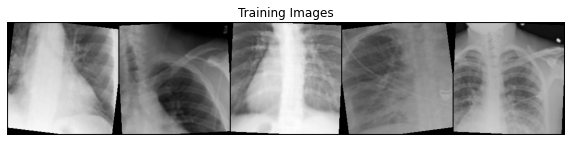

In [7]:
# Plot some training images
import torchvision.utils as vutils

iterat  = iter(valid_loader)
real_batch = next(iterat)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:5], padding=2, normalize=True).cpu(),(1,2,0)))

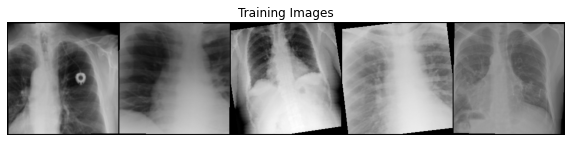

In [8]:
real_batch = next(iterat)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:5], padding=2, normalize=True).cpu(),(1,2,0)))

Model save/load location: /home/tu-molloy/group/donut/medical_ip/trained_models/model_resenet18_multi_class_multi_label_k_fold.pt
1106
batch_idx:  0
batch_idx:  1
batch_idx:  2
batch_idx:  3
batch_idx:  4
batch_idx:  5
batch_idx:  6
batch_idx:  7
batch_idx:  8
batch_idx:  9
batch_idx:  10
batch_idx:  11
batch_idx:  12
batch_idx:  13
batch_idx:  14
batch_idx:  15
batch_idx:  16
batch_idx:  17
batch_idx:  18
batch_idx:  19
batch_idx:  20
batch_idx:  21
batch_idx:  22
batch_idx:  23
batch_idx:  24
batch_idx:  25
batch_idx:  26
batch_idx:  27
batch_idx:  28
batch_idx:  29
batch_idx:  30
batch_idx:  31
batch_idx:  32
batch_idx:  33
batch_idx:  34
batch_idx:  35
batch_idx:  36
batch_idx:  37
batch_idx:  38
batch_idx:  39
batch_idx:  40
batch_idx:  41
batch_idx:  42
batch_idx:  43
batch_idx:  44
batch_idx:  45
batch_idx:  46
batch_idx:  47
batch_idx:  48
batch_idx:  49
batch_idx:  50
batch_idx:  51
batch_idx:  52
batch_idx:  53
batch_idx:  54
batch_idx:  55
batch_idx:  56
batch_idx:  57
batch

batch_idx:  515
batch_idx:  516
batch_idx:  517
batch_idx:  518
batch_idx:  519
batch_idx:  520
batch_idx:  521
batch_idx:  522
batch_idx:  523
batch_idx:  524
batch_idx:  525
batch_idx:  526
batch_idx:  527
batch_idx:  528
batch_idx:  529
batch_idx:  530
batch_idx:  531
batch_idx:  532
batch_idx:  533
batch_idx:  534
batch_idx:  535
batch_idx:  536
batch_idx:  537
batch_idx:  538
batch_idx:  539
batch_idx:  540
batch_idx:  541
batch_idx:  542
batch_idx:  543
batch_idx:  544
batch_idx:  545
batch_idx:  546
batch_idx:  547
batch_idx:  548
batch_idx:  549
batch_idx:  550
batch_idx:  551
batch_idx:  552
batch_idx:  553
batch_idx:  554
batch_idx:  555
batch_idx:  556
batch_idx:  557
batch_idx:  558
batch_idx:  559
batch_idx:  560
batch_idx:  561
batch_idx:  562
batch_idx:  563
batch_idx:  564
batch_idx:  565
batch_idx:  566
batch_idx:  567
batch_idx:  568
batch_idx:  569
batch_idx:  570
batch_idx:  571
batch_idx:  572
batch_idx:  573
batch_idx:  574
batch_idx:  575
batch_idx:  576
batch_id

batch_idx:  1026
batch_idx:  1027
batch_idx:  1028
batch_idx:  1029
batch_idx:  1030
batch_idx:  1031
batch_idx:  1032
batch_idx:  1033
batch_idx:  1034
batch_idx:  1035
batch_idx:  1036
batch_idx:  1037
batch_idx:  1038
batch_idx:  1039
batch_idx:  1040
batch_idx:  1041
batch_idx:  1042
batch_idx:  1043
batch_idx:  1044
batch_idx:  1045
batch_idx:  1046
batch_idx:  1047
batch_idx:  1048
batch_idx:  1049
batch_idx:  1050
batch_idx:  1051
batch_idx:  1052
batch_idx:  1053
batch_idx:  1054
batch_idx:  1055
batch_idx:  1056
batch_idx:  1057
batch_idx:  1058
batch_idx:  1059
batch_idx:  1060
batch_idx:  1061
batch_idx:  1062
batch_idx:  1063
batch_idx:  1064
batch_idx:  1065
batch_idx:  1066
batch_idx:  1067
batch_idx:  1068
batch_idx:  1069
batch_idx:  1070
batch_idx:  1071
batch_idx:  1072
batch_idx:  1073
batch_idx:  1074
batch_idx:  1075
batch_idx:  1076
batch_idx:  1077
batch_idx:  1078
batch_idx:  1079
batch_idx:  1080
batch_idx:  1081
batch_idx:  1082
batch_idx:  1083
batch_idx:  10

batch_idx:  1511
batch_idx:  1512
batch_idx:  1513
batch_idx:  1514
batch_idx:  1515
batch_idx:  1516
batch_idx:  1517
batch_idx:  1518
batch_idx:  1519
batch_idx:  1520
batch_idx:  1521
batch_idx:  1522
batch_idx:  1523
batch_idx:  1524
batch_idx:  1525
batch_idx:  1526
batch_idx:  1527
batch_idx:  1528
batch_idx:  1529
batch_idx:  1530
batch_idx:  1531
batch_idx:  1532
batch_idx:  1533
batch_idx:  1534
batch_idx:  1535
batch_idx:  1536
batch_idx:  1537
batch_idx:  1538
batch_idx:  1539
batch_idx:  1540
batch_idx:  1541
batch_idx:  1542
batch_idx:  1543
batch_idx:  1544
batch_idx:  1545
batch_idx:  1546
batch_idx:  1547
batch_idx:  1548
batch_idx:  1549
batch_idx:  1550
batch_idx:  1551
batch_idx:  1552
batch_idx:  1553
batch_idx:  1554
batch_idx:  1555
batch_idx:  1556
batch_idx:  1557
batch_idx:  1558
batch_idx:  1559
batch_idx:  1560
batch_idx:  1561
batch_idx:  1562
batch_idx:  1563
batch_idx:  1564
batch_idx:  1565
batch_idx:  1566
batch_idx:  1567
batch_idx:  1568
batch_idx:  15

batch_idx:  1998
batch_idx:  1999
batch_idx:  2000
batch_idx:  2001
batch_idx:  2002
batch_idx:  2003
batch_idx:  2004
batch_idx:  2005
batch_idx:  2006
batch_idx:  2007
batch_idx:  2008
batch_idx:  2009
batch_idx:  2010
batch_idx:  2011
batch_idx:  2012
batch_idx:  2013
batch_idx:  2014
batch_idx:  2015
batch_idx:  2016
batch_idx:  2017
batch_idx:  2018
batch_idx:  2019
batch_idx:  2020
batch_idx:  2021
batch_idx:  2022
batch_idx:  2023
batch_idx:  2024
batch_idx:  2025
batch_idx:  2026
batch_idx:  2027
batch_idx:  2028
batch_idx:  2029
batch_idx:  2030
batch_idx:  2031
batch_idx:  2032
batch_idx:  2033
batch_idx:  2034
batch_idx:  2035
batch_idx:  2036
batch_idx:  2037
batch_idx:  2038
batch_idx:  2039
batch_idx:  2040
batch_idx:  2041
batch_idx:  2042
batch_idx:  2043
batch_idx:  2044
batch_idx:  2045
batch_idx:  2046
batch_idx:  2047
batch_idx:  2048
batch_idx:  2049
batch_idx:  2050
batch_idx:  2051
batch_idx:  2052
batch_idx:  2053
batch_idx:  2054
batch_idx:  2055
batch_idx:  20

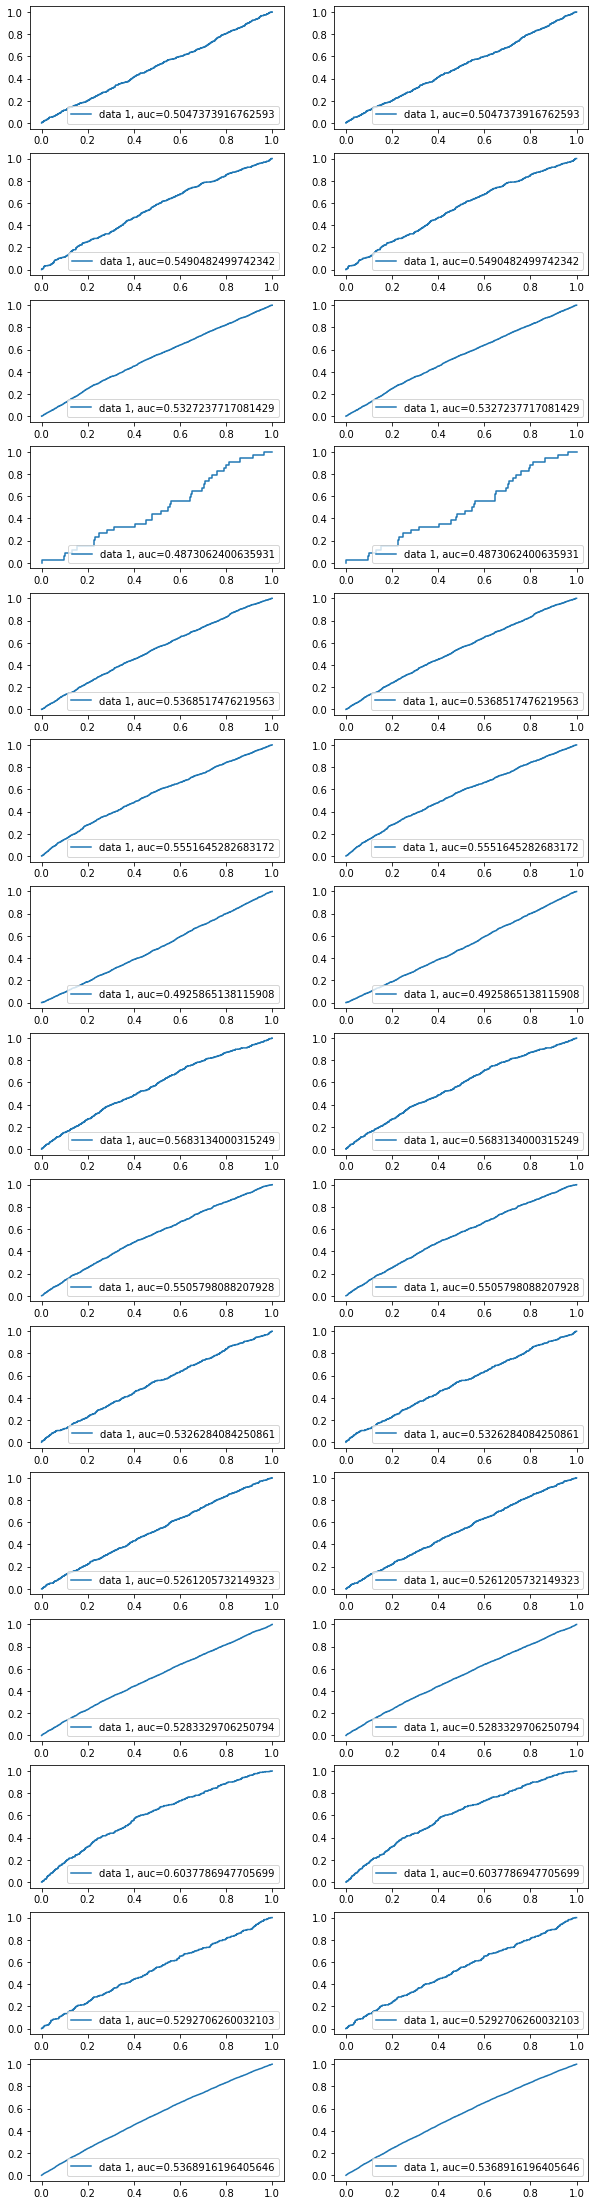

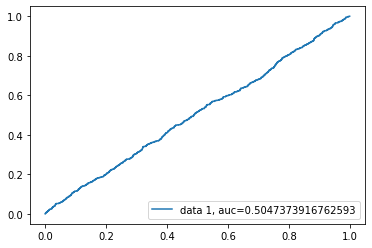

In [9]:
models_dir = os.path.expanduser('~/group/donut/medical_ip/trained_models')
model_name = 'model_resenet18_multi_class_multi_label_k_fold_0pt001_lr.pt'
models_dir = os.path.expanduser('~/group/donut/medical_ip/trained_models')
resnet_model_name= 'model_resenet18_multi_class_multi_label_k_fold.pt'
dc_gan_model_name = 'resnet18_dcgan_kfold.pt'

model_name = 'resnet18_dcgan_kfold.pt'
model_name=  resnet_model_name

model_path = os.path.join(models_dir, model_name)
print('Model save/load location: {}'.format(model_path))
model = create_model()
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.to(device)
model.eval()

outputs = np.zeros((len(test_loader)*batch_size_, 15))
labels = np.zeros((len(test_loader)*batch_size_, 15))

model.eval()
i = 0
print(len(valid_loader))
for batch_idx, (data, label) in enumerate(test_loader):
    data = data.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data).to('cpu')
    output = output.to('cpu').detach().numpy()
    labelnp = label.to('cpu').numpy()
    outputs[i:i+output.shape[0], :] = sigmoid(output)


    
    labels[i:i+output.shape[0], :] = labelnp
    i+=+output.shape[0]
    

print('loaded predictions')
fprs, tprs, roc_auc = calc_roc(labels, outputs)
print(roc_auc)
print('fpr: ', fprs[0])

import matplotlib.pyplot as plt


n_classes = 15

fig, ax = plt.subplots(nrows=n_classes, ncols=2, figsize=(10,40))
i = 0
for row in ax:
    for col in row:
        if(i< n_classes):
            print('i: ', i , ' fpr: ', fprs[i])

            col.plot(fprs[i],tprs[i],label="data 1, auc="+str(roc_auc[i]))
            col.legend(loc=4)
    i+=1

plt.show()
plt.plot(fprs[0],tprs[0],label="data 1, auc="+str(roc_auc[0]))
plt.legend(loc=4)
plt.show()


loaded predictions
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[0. 0. 0. ... 0. 0. 0.]
ylen:  (22530,)
[1. 1. 1. ... 0. 0. 0.]
{0: 0.5047373916762593, 1: 0.5490482499742342, 2: 0.5327237717081429, 3: 0.4873062400635931, 4: 0.5368517476219563, 5: 0.5551645282683172, 6: 0.4925865138115908, 7: 0.5683134000315249, 8: 0.5505798088207928, 9: 0.5326284084250861, 10: 0.5261205732149323, 11: 0.5283329706250794, 12: 0.6037786947705699, 13: 0.5292706260032103, 14: 0.5368916196405646}


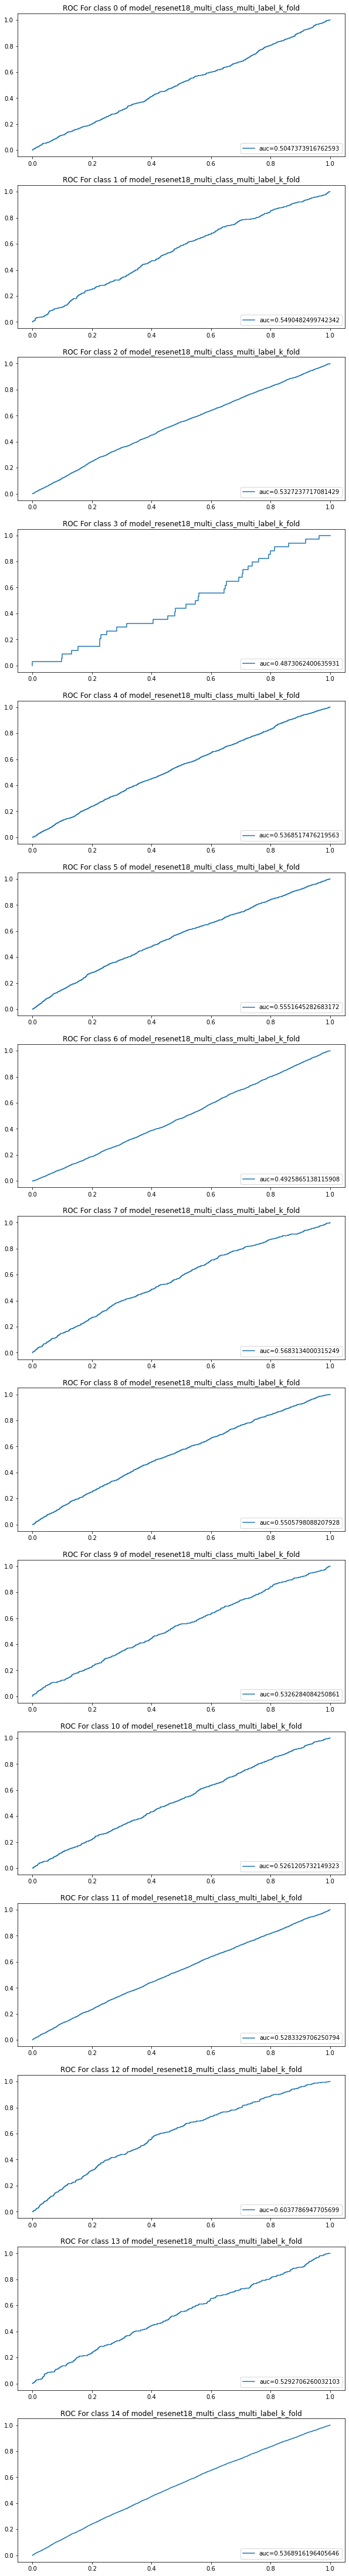

In [10]:
print('loaded predictions')
fprs, tprs, roc_auc = calc_roc(labels, outputs)
print(roc_auc)

import matplotlib.pyplot as plt


n_classes = 15

fig, ax = plt.subplots(nrows=n_classes, ncols=1, figsize=(10,80))
i = 0
for row in ax:
    #for col in row:
    if(i< n_classes):

        ax = row.plot(fprs[i],tprs[i], label="auc="+str(roc_auc[i]))
        row.title.set_text("ROC For class {} of {}".format(str(i), model_name.split('.')[0]))
        row.legend(loc=4)
        extent = row.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('../../mlmip_trained_model/{}_roc_class_{}.png'.format(model_name, i), bbox_inches=extent.expanded(1.1, 1.2))
        i+=1


plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 15)
(10, 15)
Predicted: [-3.3993518 -3.9686306 -0.767953  -6.4105296 -3.1248274 -3.1348634
 -1.3395956 -3.244248  -2.7624917 -3.515844  -2.3557794 -1.191782
 -4.6797028 -4.5555167 -0.6836621]
Predicted sigmoid: [0.03231573 0.01854874 0.31692207 0.00164145 0.04209469 0.04169187
 0.20757657 0.03753413 0.05938503 0.02886477 0.08660749 0.23294038
 0.00919641 0.01039978 0.33544445]
Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted Max : -0.6836621165275574
Actual Max : 1.0
Predicted Sigmoid Arg Max : 0.9999991684719722
Actual Arg Max : 14
-0.6836621

image batch shape:  torch.Size([10, 3, 224, 224])
single image shape:  torch.Size([3, 224, 224])
img_1channel shape:  (224, 224)
img_3channel shape: torch.Size([224, 224, 3])
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.

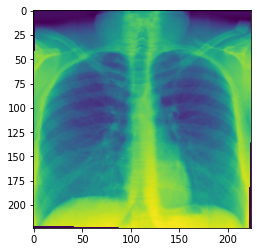

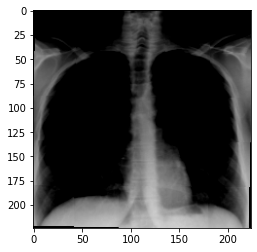

In [11]:

# Doing inference on cpu as it doesn't take much effort feel free to change.
# Had some trouble loading it on GPU. 
iterat  = iter(valid_loader)
image, label = next(iterat)
image, label = next(iterat)


model = create_model()
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

data = image.to('cpu')
# forward pass: compute predicted outputs by passing inputs to the model
output = model(data)
output = output.to('cpu').detach().numpy()
target = label.to('cpu').detach().numpy()
cur = 7
print(np.shape(target))
print(np.shape(output))

print("Predicted: {}".format(output[cur]))
print("Predicted sigmoid: {}".format(sigmoid(output[cur])))

print("Actual: {}".format(target[cur]))

print("Predicted Max : {}".format(output[cur].max()))
print("Actual Max : {}".format(target[cur].max()))

print("Predicted Sigmoid Arg Max : {}".format(sigmoid(output[cur].argmax())))
print("Actual Arg Max : {}".format(target[cur].argmax()))


print(output[cur].max())
print("\nimage batch shape: ", image.shape)
print("single image shape: ", image[cur].shape)




# 1 channel image
img_1_channel = image.numpy()[cur][1]
print("img_1channel shape: ", img_1_channel.shape)
plt.figure()
plt.imshow(img_1_channel)

# 3 channel image
plt.figure()
img_3_channel = image[cur].permute(1, 2, 0)
plt.imshow(img_3_channel, cmap='cool')
print("img_3channel shape:", img_3_channel.shape)

# print label
print("labels:",label)


# Test classficaton on a single image.